# Trabajo Practico
## Desarrollo de Modelos Analíticos (Machine Learning) K5051 -2024
### Grupo 3
#### Nigliazzo, Matias Ezequiel
#### Choque Llanqui, Edson Gustavo
#### Sanchez, Tomas Agustin

#### Lectura de archivo de datos

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('future.no_silent_downcasting', True)

# Leer el archivo data.csv
data=pd.read_csv('data/data.csv',sep='|',dtype={'client_id':int,'Target':int},skipfooter = 1, engine='python')
data.shape

(238615, 77)

In [151]:
print("Cantidad de registros de cada mes: ")
data.Month.value_counts(sort=True,ascending=True)

Cantidad de registros de cada mes: 


Month
2018-10-01    26501
2018-09-01    26501
2018-12-01    26501
2018-11-01    26501
2018-08-01    26502
2019-01-01    26503
2019-02-01    26512
2019-04-01    26547
2019-03-01    26547
Name: count, dtype: int64

In [152]:
print("Cantidad de clientes: ",len(data.client_id.unique()))

Cantidad de clientes:  26560


#### Universo

In [153]:
data_9m = pd.DataFrame(data.client_id.value_counts().reset_index(name='q_meses')).query('q_meses >= 9')
data_9m

,client_id,q_meses
0,5856970,9
1,5895899,9
2,4712252,9
3,7304330,9
4,6657428,9
...,...,...
26478,4205458,9
26479,2964835,9
26480,6350133,9
26481,2068261,9


In [154]:
mes_data=data[['Month']].drop_duplicates().sort_values(by='Month',ascending=False)
mes_data

,Month
9,2019-04-01
35,2019-03-01
8,2019-02-01
2,2019-01-01
3,2018-12-01
18,2018-11-01
0,2018-10-01
1,2018-09-01
23,2018-08-01


In [155]:
mes_prediction=mes_data[0:2]
mes_prediction

,Month
9,2019-04-01
35,2019-03-01


In [156]:
mes_lead=mes_data[2:3]
mes_lead

,Month
8,2019-02-01


In [157]:
mes_training=mes_data[3::]
mes_training

,Month
2,2019-01-01
3,2018-12-01
18,2018-11-01
0,2018-10-01
1,2018-09-01
23,2018-08-01


In [158]:
ultimo_mes=mes_training.max().to_string(index=False)
ultimo_mes

'2019-01-01'

In [159]:
data_sin_paquete=data[(data.Package_Active=='No') & (data.Month==ultimo_mes)][['client_id']]
data_sin_paquete

,client_id
2,5928737
10,6018047
11,5359038
16,6890812
20,115383
...,...
238573,6570413
238574,6258895
238585,6397274
238586,6007291


In [160]:
data_sin_cobranding=data[(data.CreditCard_CoBranding=='No') & (data.Month==ultimo_mes)][['client_id']]
data_sin_cobranding

,client_id
2,5928737
10,6018047
11,5359038
16,6890812
20,115383
...,...
238573,6570413
238574,6258895
238585,6397274
238586,6007291


In [161]:
universo=data_9m\
    .merge(data_sin_paquete,how='inner',on='client_id')\
    .merge(data_sin_cobranding,how='inner',on='client_id')
universo

,client_id,q_meses
0,5856970,9
1,5895899,9
2,4712252,9
3,6657428,9
4,6604065,9
...,...,...
23186,5489595,9
23187,4205458,9
23188,2964835,9
23189,6350133,9


In [162]:
data_universo=data.merge(universo, how='inner', on='client_id')

In [163]:
data_target_1=data_universo[(data_universo.Target==1) & (data_universo.Month.isin(mes_prediction['Month']))][['client_id']].drop_duplicates()
data_target_1['Target']=1
data_target_1.shape

(6823, 2)

In [164]:
data_target=universo.merge(data_target_1,how='left',on='client_id').fillna(0)

In [165]:
porcentaje_1=round(len(data_target[(data_target.Target==1)])*100/ len(data_target),0)
porcentaje_0=100-porcentaje_1
if porcentaje_0!=porcentaje_1:
    print("Desbalanceado")
else:    
    print("Balanceado")

print ("Porcentaje de Target=1: " +str( porcentaje_1)+ "%")
print ("Porcentaje de Target=0: " +str( porcentaje_0)+ "%")

data_target.Target.value_counts()

Desbalanceado
Porcentaje de Target=1: 29.0%
Porcentaje de Target=0: 71.0%


Target
0.0    16368
1.0     6823
Name: count, dtype: int64

#### Preprocessing and Transformation

In [166]:
data_training=data_universo.merge(mes_training,how='inner',on='Month')
data_training.rename(columns={'Target_x':'Target'},inplace=True)
data_training['Sex_F']=data_training['Sex']=='F'
data_training.drop(columns=['Sex'],inplace=True)
data_training=data_training.replace('Yes',1).replace('No',0)
data_training

,client_id,Target,Month,First_product_dt,Last_product_dt,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,...,CreditCard_Payment_Web,CreditCard_Payment_ATM,CreditCard_Payment_TAS,Investment_Numbers,Mobile,Email,Region,CreditCard_Product,q_meses,Sex_F
0,5856970,1,2018-10-01,2013-10-23,2019-01-10,0,1,0,0,0,...,0.0,0.0,0.0,1.0,1,1,NaN,NaN,9,True
1,6371753,0,2018-09-01,2015-07-29,2018-06-02,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1,0,NaN,NaN,9,True
2,5928737,0,2019-01-01,2016-08-31,2018-12-27,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1,1,NaN,NaN,9,False
3,475064,0,2018-12-01,2014-07-13,2017-11-30,0,1,0,0,0,...,0.0,0.0,0.0,0.0,1,1,NaN,NaN,9,True
4,3615172,0,2018-09-01,2017-12-27,2017-12-28,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1,0,NaN,NaN,9,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139141,1673642,0,2018-11-01,2017-08-18,2017-09-26,0,1,0,0,0,...,1.0,0.0,0.0,0.0,0,1,NaN,NaN,9,False
139142,6145735,1,2018-11-01,2014-10-26,2014-10-26,0,1,0,0,0,...,1.0,0.0,0.0,0.0,1,1,NaN,NaN,9,False
139143,5638786,1,2018-11-01,2012-12-26,2017-03-08,0,1,0,0,0,...,0.0,0.0,1.0,0.0,1,0,NaN,NaN,9,True
139144,3824781,0,2018-08-01,2014-11-27,2019-01-04,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1,1,NaN,NaN,9,False


##### Tipos de datos

Fechas: `Month`, `First_product_dt` y `Last_product_dt`

Categorica: `Region`, `CreditCard_Product`, `Client_Age_grp`

El resto son numericas



In [167]:
data_universo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208719 entries, 0 to 208718
Data columns (total 78 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   client_id                                      208719 non-null  int32  
 1   Target                                         208719 non-null  int32  
 2   Month                                          208719 non-null  object 
 3   First_product_dt                               208719 non-null  object 
 4   Last_product_dt                                208719 non-null  object 
 5   CreditCard_Premium                             208719 non-null  object 
 6   CreditCard_Active                              208719 non-null  object 
 7   CreditCard_CoBranding                          208719 non-null  object 
 8   Loan_Active                                    208719 non-null  object 
 9   Mortgage_Active                      

##### Variables


In [168]:
variables_paquete=[
               'Client_Age_grp'
               ,'CreditCard_Total_Limit'
               ,'CreditCard_Total_Spending'
               ,'CreditCard_Premium'
               ,'CreditCard_Active'
               ,'CreditCard_Product'
               ,'CreditCard_Spending_Installments'
               ,'CreditCard_Spending_CrossBoarder'
               ,'CreditCard_Revolving'
               ,'CreditCard_Balance_ARG'
               ,'CreditCard_Balance_DOLLAR'
               ,'DebitCard_Active'
               ,'SavingAccount_Active_ARG'
               ,'SavingAccount_Active_DOLLAR'
               ,'SavingAccount_Active_ARG_Salary'
               ,'SavingAccount_Days_with_use'
               ,'SavingAccount_CreditCard_Payment_Amount'
               ,'SavingAccount_DebitCard_Spend_Transactions'
               ,'SavingAccount_Transactions_Transactions'
               ,'SavingAccount_Total_Amount'
               ,'SavingAccount_Balance_Average'
               ,'SavingAccount_Credits_Amounts'
               ,'SavingAccount_Debits_Amounts'
               ,'Insurance_Life'
               ,'Insurance_Home'
               ,'Insurance_Accidents'
               ,'Insurance_Mobile'
               ,'Insurance_ATM'
               ,'Insurance_Unemployment'
               ,'Investment_Active'
               ,'Mortgage_Active'
               ,'Loan_Active'
               ,'SavingAccount_Balance_FirstDate'
               ,'Sex_F'
               ,'Region'
               ,'First_product_dt'  
               ,'Last_product_dt'
               ,'CreditCard_Spending_Aut_Debits'
               ,'Operations_Bank'
               ,'Operations_Terminal'
               ,'Operations_HomeBanking'
               ,'Operations_Mobile'
               ,'Operations_Ivr'
               ,'Operations_Telemarketer'
               ,'Operations_ATM']

print ("Se seleccionaron ",str(len(variables_paquete))+' variables')
print ("Variables relacionadas con el paquete: ",variables_paquete)
variables_con_identificador=variables_paquete
variables_con_identificador.append('client_id')
variables_con_identificador.append('Target')
variables_con_identificador.append('Month')
data_training[variables_con_identificador]

Se seleccionaron  45 variables
Variables relacionadas con el paquete:  ['Client_Age_grp', 'CreditCard_Total_Limit', 'CreditCard_Total_Spending', 'CreditCard_Premium', 'CreditCard_Active', 'CreditCard_Product', 'CreditCard_Spending_Installments', 'CreditCard_Spending_CrossBoarder', 'CreditCard_Revolving', 'CreditCard_Balance_ARG', 'CreditCard_Balance_DOLLAR', 'DebitCard_Active', 'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR', 'SavingAccount_Active_ARG_Salary', 'SavingAccount_Days_with_use', 'SavingAccount_CreditCard_Payment_Amount', 'SavingAccount_DebitCard_Spend_Transactions', 'SavingAccount_Transactions_Transactions', 'SavingAccount_Total_Amount', 'SavingAccount_Balance_Average', 'SavingAccount_Credits_Amounts', 'SavingAccount_Debits_Amounts', 'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents', 'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment', 'Investment_Active', 'Mortgage_Active', 'Loan_Active', 'SavingAccount_Balance_FirstDate', 'Sex_F', 'Region', 'Fi

,Client_Age_grp,CreditCard_Total_Limit,CreditCard_Total_Spending,CreditCard_Premium,CreditCard_Active,CreditCard_Product,CreditCard_Spending_Installments,CreditCard_Spending_CrossBoarder,CreditCard_Revolving,CreditCard_Balance_ARG,...,Operations_Bank,Operations_Terminal,Operations_HomeBanking,Operations_Mobile,Operations_Ivr,Operations_Telemarketer,Operations_ATM,client_id,Target,Month
0,Mayor a 70 años,64000.0,8021.05,0,1,NaN,5650.47,0.00,0.00,9823.39,...,0.0,2.0,1.0,0.0,1.0,0.0,1.0,5856970,1,2018-10-01
1,Entre 50 y 59 años,0.0,0.00,0,0,NaN,0.00,0.00,0.00,0.00,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,6371753,0,2018-09-01
2,Entre 30 y 39 años,0.0,0.00,0,0,NaN,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5928737,0,2019-01-01
3,Mayor a 70 años,112000.0,2418.48,0,1,NaN,2056.47,0.00,0.00,2585.28,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,475064,0,2018-12-01
4,Entre 40 y 49 años,0.0,0.00,0,0,NaN,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3615172,0,2018-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139141,Entre 30 y 39 años,32000.0,4735.82,0,1,NaN,4316.89,10.43,16.13,7682.23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1673642,0,2018-11-01
139142,Entre 50 y 59 años,56000.0,36165.12,0,1,NaN,19435.37,0.00,0.00,37889.46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6145735,1,2018-11-01
139143,Entre 65 y 69 años,28000.0,270.00,0,1,NaN,0.00,0.00,-300.00,-30.00,...,1.0,5.0,0.0,0.0,0.0,0.0,0.0,5638786,1,2018-11-01
139144,Entre 65 y 69 años,0.0,0.00,0,0,NaN,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3824781,0,2018-08-01


In [169]:
data_training=data_training[data_training.Month==ultimo_mes][variables_paquete].copy()

##### Miss Values

In [170]:
data_training.columns[data_training.isnull().any()].tolist()

['CreditCard_Product', 'SavingAccount_Balance_Average', 'Region']

###### SavingAccount_Balance_Average

In [171]:
data_training['SavingAccount_Balance_Average'] = np.where(data_training.SavingAccount_Balance_Average.isnull(), 
   data_training.SavingAccount_Balance_FirstDate - data_training.SavingAccount_Debits_Amounts + data_training.SavingAccount_Credits_Amounts , 
   data_training.SavingAccount_Balance_Average)

data_training.columns[data_training.isnull().any()].tolist()

['CreditCard_Product', 'Region']

###### Region

In [172]:
col='Region'
data_tmp=data.query(col+'.notnull()')[['client_id',col]].groupby('client_id').first().reset_index()
data_tmp.columns=['client_id',col+'_NOTNULL']
data_training=data_training.merge(data_tmp,how='left',on='client_id')
data_training[col]=data_training[col].fillna(data_training[col+'_NOTNULL']).fillna('BUENOS AIRES')
data_training.drop(columns=[col+'_NOTNULL'],inplace=True)
print (data_training[[col]].value_counts())

Region                       
BUENOS AIRES                     6990
REGION CENTRO                    4579
REGION NORTE GRANDE ARGENTINO    3674
REGION PATAGONICA                2432
CABA Centro/Norte                2048
AMBA Resto                       1828
REGION CUYO                      1640
Name: count, dtype: int64


###### CreditCard_Product

In [173]:
data_training['CreditCard_Product']=np.where(data_training.CreditCard_Active==0,'No',data_training.CreditCard_Product)
data_training.groupby(['CreditCard_Product']).size()

CreditCard_Product
No    8168
dtype: int64

In [174]:
col='CreditCard_Product'
data_tmp=data.query(col+'.notnull()')[['client_id',col]].groupby('client_id').first().reset_index()
data_tmp.columns=['client_id',col+'_NOTNULL']
data_training=data_training.merge(data_tmp,how='left',on='client_id')
data_training[col]=data_training[col].fillna(data_training[col+'_NOTNULL'])
data_training.drop(columns=[col+'_NOTNULL'],inplace=True)

data_training.groupby(['CreditCard_Product']).size()

CreditCard_Product
J55660102XX012     402
J55660104XX012    8279
J55660123XX012       1
J55660124XX012      29
J55660202XX012    5775
J55660702XX012     251
J55661002XX012      58
No                8168
dtype: int64

##### Transform Features

In [175]:
Transform_Features=[
               'Client_Age_grp'
               ,'CreditCard_Total_Spending'
               ,'SavingAccount_Total_Amount'
               ,'SavingAccount_Balance_Average'
               ,'DebitCard_Active'
               ,'CreditCard_Premium'
               ,'CreditCard_Active'
               ,'SavingAccount_Active_ARG'
               ,'SavingAccount_Active_DOLLAR'
               ,'SavingAccount_Active_ARG_Salary'
               ,'Insurance_Life'
               ,'Insurance_Home'
               ,'Insurance_Accidents'
               ,'Insurance_Mobile'
               ,'Insurance_ATM'
               ,'Insurance_Unemployment'
               ,'Investment_Active'
               ,'Mortgage_Active'
               ,'Loan_Active'
               ,'SavingAccount_Percent_Credit'
               ,'ProductAge'
               ,'IsLastProductMonth'
               ,'HasAutomaticDebit'
               ,'HasInsurance'
               ,'TotalOperations']
# SavingAccount_Percent_Credit
data_training['SavingAccount_Percent_Credit']=data_training['SavingAccount_Credits_Amounts']/data_training['SavingAccount_Total_Amount']
data_training['SavingAccount_Percent_Credit']=data_training['SavingAccount_Percent_Credit'].fillna(0)

# ProductAge
data_training['ProductAge']=(pd.to_datetime(data_training['Month'])-pd.to_datetime(data_training['First_product_dt'])).dt.days.where(pd.to_datetime(data_training['Month'])>pd.to_datetime(data_training['First_product_dt']),0)

# IsLastProductMonth
data_training['IsLastProductMonth']=(pd.to_datetime(data_training['Month']).dt.to_period('M')==pd.to_datetime(data_training['Last_product_dt']).dt.to_period('M')).astype(int)

#HasAutomaticDebit
data_training['HasAutomaticDebit']=data_training['CreditCard_Spending_Aut_Debits']>0

#HasInsurance
data_training['HasInsurance']=data_training['Insurance_Life']+data_training['Insurance_Home']+data_training['Insurance_Accidents']+data_training['Insurance_Mobile']+data_training['Insurance_ATM']+data_training['Insurance_Unemployment']>0

# TotalOperations
data_training['TotalOperations'] = data_training['Operations_Bank'] + data_training['Operations_Terminal'] \
                                + data_training['Operations_HomeBanking'] + data_training['Operations_Mobile'] \
                                + data_training['Operations_Ivr'] + data_training['Operations_Telemarketer'] \
                                + data_training['Operations_ATM']
Transform_Features_client=Transform_Features
Transform_Features_client.append('client_id')
Transform_Features_client.append('Target')
data_transform=data_training[(data_training.Month==ultimo_mes)][Transform_Features_client]
data_transform

,Client_Age_grp,CreditCard_Total_Spending,SavingAccount_Total_Amount,SavingAccount_Balance_Average,DebitCard_Active,CreditCard_Premium,CreditCard_Active,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,SavingAccount_Active_ARG_Salary,...,Mortgage_Active,Loan_Active,SavingAccount_Percent_Credit,ProductAge,IsLastProductMonth,HasAutomaticDebit,HasInsurance,TotalOperations,client_id,Target
0,Entre 30 y 39 años,0.00,0.00,0.00,1,0,0,1,1,0,...,0,0,0.000000,853,0,False,False,0.0,5928737,0
1,Entre 60 y 64 años,16068.08,0.00,71.60,1,1,1,1,0,0,...,0,0,0.000000,1708,0,True,False,1.0,6018047,1
2,Entre 40 y 49 años,6919.64,116177.47,14060.84,1,1,1,1,1,1,...,0,1,0.388580,1090,0,True,False,16.0,5359038,1
3,Entre 40 y 49 años,0.00,13522.63,1528.78,1,0,0,1,1,0,...,0,1,0.500061,571,0,False,False,5.0,6890812,0
4,Mayor a 70 años,0.00,0.00,343.60,0,0,0,1,0,0,...,0,0,0.000000,5268,0,False,False,0.0,115383,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,Entre 30 y 39 años,0.00,20824.19,1835.76,1,0,1,1,1,0,...,0,0,0.504228,1124,0,False,False,6.0,6570413,0
23187,Entre 30 y 39 años,0.00,4487.84,430.07,1,0,0,1,1,0,...,0,0,0.668473,1391,0,False,False,0.0,6258895,0
23188,Entre 40 y 49 años,1384.27,0.00,0.00,0,0,1,0,0,0,...,0,0,0.000000,1288,0,True,False,0.0,6397274,0
23189,Entre 40 y 49 años,32977.86,0.00,0.00,0,1,1,0,0,0,...,0,0,0.000000,1724,0,True,False,0.0,6007291,0


In [176]:
data_transform['Client_Age_grp'].value_counts()

Client_Age_grp
Entre 40 y 49 años    6563
Entre 30 y 39 años    5308
Entre 50 y 59 años    5149
Entre 60 y 64 años    2122
Entre 65 y 69 años    1745
Mayor a 70 años       1315
Entre 18 y 29 años     989
Name: count, dtype: int64

##### Identity Features

In [177]:
Identity_Features=[
                'CreditCard_Total_Limit'
               ,'CreditCard_Product'
               ,'CreditCard_Spending_Installments'
               ,'CreditCard_Spending_CrossBoarder'
               ,'CreditCard_Revolving'
               ,'CreditCard_Balance_ARG'
               ,'CreditCard_Balance_DOLLAR'
               ,'SavingAccount_Days_with_use'
               ,'SavingAccount_CreditCard_Payment_Amount'
               ,'SavingAccount_DebitCard_Spend_Transactions'
               ,'SavingAccount_Transactions_Transactions'
               ,'SavingAccount_Credits_Amounts'
               ,'SavingAccount_Debits_Amounts'
               ,'Sex_F'
               ,'Region']

Identity_Features_ClientId=Identity_Features
Identity_Features_ClientId.append('client_id')
data_identity=data_training[data_training.Month==ultimo_mes][Identity_Features_ClientId]
data_identity

,CreditCard_Total_Limit,CreditCard_Product,CreditCard_Spending_Installments,CreditCard_Spending_CrossBoarder,CreditCard_Revolving,CreditCard_Balance_ARG,CreditCard_Balance_DOLLAR,SavingAccount_Days_with_use,SavingAccount_CreditCard_Payment_Amount,SavingAccount_DebitCard_Spend_Transactions,SavingAccount_Transactions_Transactions,SavingAccount_Credits_Amounts,SavingAccount_Debits_Amounts,Sex_F,Region,client_id
0,0.0,No,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,False,REGION NORTE GRANDE ARGENTINO,5928737
1,80000.0,J55660104XX012,240.00,0.00,-14.31,16397.20,0.00,0.0,0.00,0.0,0.0,0.00,0.00,False,BUENOS AIRES,6018047
2,64000.0,J55660104XX012,4747.07,33.57,0.00,6906.73,33.67,16.0,8651.75,18.0,39.0,45144.21,71033.26,False,REGION NORTE GRANDE ARGENTINO,5359038
3,0.0,No,0.00,0.00,0.00,0.00,0.00,3.0,0.00,0.0,4.0,6762.14,6760.49,False,REGION NORTE GRANDE ARGENTINO,6890812
4,0.0,No,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,False,AMBA Resto,115383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,28000.0,J55660104XX012,0.00,0.00,0.00,537.43,0.00,3.0,537.43,0.0,4.0,10500.14,10324.05,True,REGION PATAGONICA,6570413
23187,0.0,No,0.00,0.00,0.00,0.00,0.00,4.0,0.00,0.0,5.0,3000.00,1487.84,True,BUENOS AIRES,6258895
23188,40000.0,J55660104XX012,925.27,0.00,-77.32,1475.18,0.00,0.0,0.00,0.0,0.0,0.00,0.00,False,REGION CENTRO,6397274
23189,96000.0,J55660202XX012,5268.31,0.00,0.00,33148.43,0.00,0.0,0.00,0.0,0.0,0.00,0.00,True,CABA Centro/Norte,6007291


##### Aggregate Features

In [178]:
Features=Identity_Features
Features.remove('Region')
Features.remove('CreditCard_Product')
Features.remove('Sex_F')
Features.remove('client_id')
Features.append('CreditCard_Total_Spending')
Features.append('SavingAccount_Total_Amount')
Features.append('SavingAccount_Balance_Average')
Features.append('SavingAccount_Percent_Credit')
Features.append('ProductAge')
Features.append('TotalOperations')
print(Features)

['CreditCard_Total_Limit', 'CreditCard_Spending_Installments', 'CreditCard_Spending_CrossBoarder', 'CreditCard_Revolving', 'CreditCard_Balance_ARG', 'CreditCard_Balance_DOLLAR', 'SavingAccount_Days_with_use', 'SavingAccount_CreditCard_Payment_Amount', 'SavingAccount_DebitCard_Spend_Transactions', 'SavingAccount_Transactions_Transactions', 'SavingAccount_Credits_Amounts', 'SavingAccount_Debits_Amounts', 'CreditCard_Total_Spending', 'SavingAccount_Total_Amount', 'SavingAccount_Balance_Average', 'SavingAccount_Percent_Credit', 'ProductAge', 'TotalOperations']


In [179]:
last_3m=mes_training[0:3]
data_last_3m=data_training[data_training.Month.isin(last_3m['Month'])]
data_client_id=data_training[['client_id']].drop_duplicates()
aggregate_acumulado=data_client_id
for col in Features:
    aggregate=data_last_3m.groupby('client_id').agg({col: ['mean', 'min', 'max','median','sum','var',lambda x: x.ne(0).sum(),'first','last']})
    aggregate.columns=[col+'_mean_3m',col+'_min_3m',col+'_max_3m',col+'_median_3m',col+'_sum_3m',col+'_var_3m',col+'_countnotzero_3m',col+'_first_3m',col+'_last_3m']
    aggregate[col+'_diff_3m']=aggregate[col+'_last_3m']-aggregate[col+'_first_3m']
    aggregate.drop(columns=[col+'_first_3m',col+'_last_3m'],inplace=True)
    aggregate_acumulado=data_client_id.merge(aggregate,how='left',on='client_id').merge(aggregate_acumulado,how='left',on='client_id').fillna(0)
aggregate_acumulado.columns

Index(['client_id', 'TotalOperations_mean_3m', 'TotalOperations_min_3m',
       'TotalOperations_max_3m', 'TotalOperations_median_3m',
       'TotalOperations_sum_3m', 'TotalOperations_var_3m',
       'TotalOperations_countnotzero_3m', 'TotalOperations_diff_3m',
       'ProductAge_mean_3m',
       ...
       'CreditCard_Spending_Installments_countnotzero_3m',
       'CreditCard_Spending_Installments_diff_3m',
       'CreditCard_Total_Limit_mean_3m', 'CreditCard_Total_Limit_min_3m',
       'CreditCard_Total_Limit_max_3m', 'CreditCard_Total_Limit_median_3m',
       'CreditCard_Total_Limit_sum_3m', 'CreditCard_Total_Limit_var_3m',
       'CreditCard_Total_Limit_countnotzero_3m',
       'CreditCard_Total_Limit_diff_3m'],
      dtype='object', length=145)

In [180]:
last_6m=mes_training[0:6]
data_last_6m=data_training[data_training.Month.isin(last_6m['Month'])]
data_client_id=data_training[['client_id']].drop_duplicates()
aggregate_acumulado=data_client_id
for col in Features:
    aggregate=data_last_6m.groupby('client_id').agg({col: ['mean', 'min', 'max','median','sum','var',lambda x: x.ne(0).sum(),'first','last']})
    aggregate.columns=[col+'_mean_6m',col+'_min_6m',col+'_max_6m',col+'_median_6m',col+'_sum_6m',col+'_var_6m',col+'_countnotzero_6m',col+'_first_6m',col+'_last_6m']
    aggregate[col+'_diff_6m']=aggregate[col+'_last_6m']-aggregate[col+'_first_6m']
    aggregate.drop(columns=[col+'_first_6m',col+'_last_6m'],inplace=True)
    aggregate_acumulado=data_client_id.merge(aggregate,how='left',on='client_id').merge(aggregate_acumulado,how='left',on='client_id').fillna(0)

aggregate_acumulado.columns

Index(['client_id', 'TotalOperations_mean_6m', 'TotalOperations_min_6m',
       'TotalOperations_max_6m', 'TotalOperations_median_6m',
       'TotalOperations_sum_6m', 'TotalOperations_var_6m',
       'TotalOperations_countnotzero_6m', 'TotalOperations_diff_6m',
       'ProductAge_mean_6m',
       ...
       'CreditCard_Spending_Installments_countnotzero_6m',
       'CreditCard_Spending_Installments_diff_6m',
       'CreditCard_Total_Limit_mean_6m', 'CreditCard_Total_Limit_min_6m',
       'CreditCard_Total_Limit_max_6m', 'CreditCard_Total_Limit_median_6m',
       'CreditCard_Total_Limit_sum_6m', 'CreditCard_Total_Limit_var_6m',
       'CreditCard_Total_Limit_countnotzero_6m',
       'CreditCard_Total_Limit_diff_6m'],
      dtype='object', length=145)

##### ABT

In [181]:
abt=aggregate_acumulado.merge(data_transform,how='inner',on='client_id').merge(data_identity,how='inner',on='client_id')
abt

,client_id,TotalOperations_mean_6m,TotalOperations_min_6m,TotalOperations_max_6m,TotalOperations_median_6m,TotalOperations_sum_6m,TotalOperations_var_6m,TotalOperations_countnotzero_6m,TotalOperations_diff_6m,ProductAge_mean_6m,...,CreditCard_Balance_ARG,CreditCard_Balance_DOLLAR,SavingAccount_Days_with_use,SavingAccount_CreditCard_Payment_Amount,SavingAccount_DebitCard_Spend_Transactions,SavingAccount_Transactions_Transactions,SavingAccount_Credits_Amounts,SavingAccount_Debits_Amounts,Sex_F,Region
0,5928737,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,853.0,...,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,False,REGION NORTE GRANDE ARGENTINO
1,6018047,1.0,1.0,1.0,1.0,1.0,0.0,1,0.0,1708.0,...,16397.20,0.00,0.0,0.00,0.0,0.0,0.00,0.00,False,BUENOS AIRES
2,5359038,16.0,16.0,16.0,16.0,16.0,0.0,1,0.0,1090.0,...,6906.73,33.67,16.0,8651.75,18.0,39.0,45144.21,71033.26,False,REGION NORTE GRANDE ARGENTINO
3,6890812,5.0,5.0,5.0,5.0,5.0,0.0,1,0.0,571.0,...,0.00,0.00,3.0,0.00,0.0,4.0,6762.14,6760.49,False,REGION NORTE GRANDE ARGENTINO
4,115383,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,5268.0,...,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,False,AMBA Resto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,6570413,6.0,6.0,6.0,6.0,6.0,0.0,1,0.0,1124.0,...,537.43,0.00,3.0,537.43,0.0,4.0,10500.14,10324.05,True,REGION PATAGONICA
23187,6258895,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1391.0,...,0.00,0.00,4.0,0.00,0.0,5.0,3000.00,1487.84,True,BUENOS AIRES
23188,6397274,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1288.0,...,1475.18,0.00,0.0,0.00,0.0,0.0,0.00,0.00,False,REGION CENTRO
23189,6007291,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1724.0,...,33148.43,0.00,0.0,0.00,0.0,0.0,0.00,0.00,True,CABA Centro/Norte


##### Outliers


Three sigma  65664.58387662686


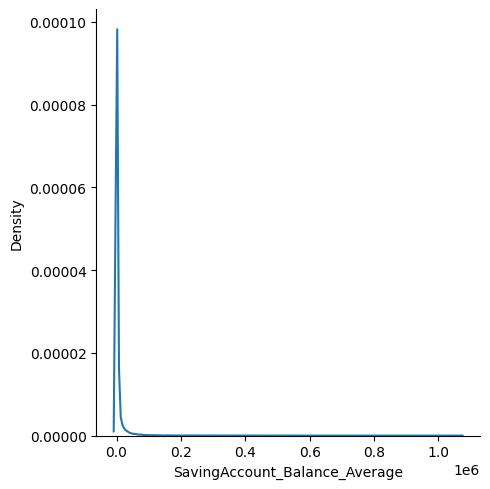

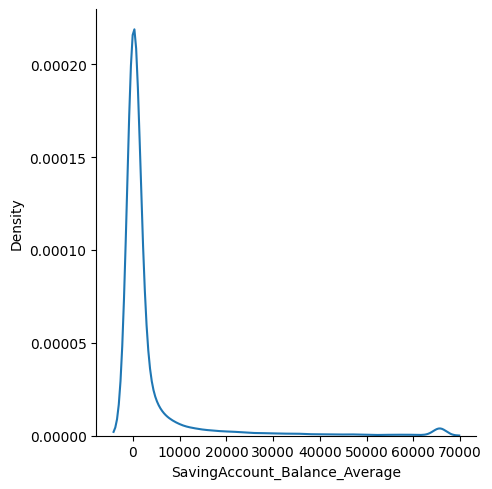

count    23191.000000
mean      3436.220177
std      10291.749729
min         -0.020000
25%          0.000000
50%         12.080000
75%       1505.200000
max      65664.583877
Name: SavingAccount_Balance_Average, dtype: float64

In [182]:
sns.displot(abt['SavingAccount_Balance_Average'], kind='kde')

three_sigma = 3 * abt['SavingAccount_Balance_Average'].std()
print('Three sigma ', three_sigma)

abt['SavingAccount_Balance_Average'] = np.where(abt['SavingAccount_Balance_Average'] > three_sigma, 
                                                          three_sigma,
                                                         abt['SavingAccount_Balance_Average'])


sns.displot(abt['SavingAccount_Balance_Average'], kind='kde')

# display the plot
plt.show()
abt['SavingAccount_Balance_Average'].describe()

In [183]:
columns=Features
agg_colums=[x for x in abt.columns if x.endswith('_3m')]+[x for x in abt.columns if x.endswith('_6m')]
columns=columns+agg_colums
columns.remove('SavingAccount_Balance_Average')
for col in columns:
    three_sigma = 3 * abt[col].std()
    print(col)
    print(abt[col].describe())
    print('Three sigma ', three_sigma)
    abt[col] = np.where(abt[col] > three_sigma, 
                                                            three_sigma,
                                                            abt[col])
abt


CreditCard_Total_Limit
count     23191.000000
mean      49607.272218
std       59737.464407
min           0.000000
25%           0.000000
50%       40000.000000
75%       64000.000000
max      625000.000000
Name: CreditCard_Total_Limit, dtype: float64
Three sigma  179212.39322093304
CreditCard_Spending_Installments
count    23191.000000
mean      1776.586115
std       3185.093095
min          0.000000
25%          0.000000
50%         83.300000
75%       2484.655000
max      54774.050000
Name: CreditCard_Spending_Installments, dtype: float64
Three sigma  9555.279284632797
CreditCard_Spending_CrossBoarder
count    23191.000000
mean         8.498411
std         78.686432
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2570.400000
Name: CreditCard_Spending_CrossBoarder, dtype: float64
Three sigma  236.05929665507415
CreditCard_Revolving
count     23191.000000
mean       2143.647603
std        7910.096603
min      -84166.390000
25%         

,client_id,TotalOperations_mean_6m,TotalOperations_min_6m,TotalOperations_max_6m,TotalOperations_median_6m,TotalOperations_sum_6m,TotalOperations_var_6m,TotalOperations_countnotzero_6m,TotalOperations_diff_6m,ProductAge_mean_6m,...,CreditCard_Balance_ARG,CreditCard_Balance_DOLLAR,SavingAccount_Days_with_use,SavingAccount_CreditCard_Payment_Amount,SavingAccount_DebitCard_Spend_Transactions,SavingAccount_Transactions_Transactions,SavingAccount_Credits_Amounts,SavingAccount_Debits_Amounts,Sex_F,Region
0,5928737,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,853.000000,...,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,False,REGION NORTE GRANDE ARGENTINO
1,6018047,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.0,0.0,1708.000000,...,16397.20,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,False,BUENOS AIRES
2,5359038,14.895733,14.895733,14.895733,14.895733,14.895733,0.0,1.0,0.0,1090.000000,...,6906.73,33.67,12.524614,8651.75,15.402312,32.001337,45144.21,71033.26,False,REGION NORTE GRANDE ARGENTINO
3,6890812,5.000000,5.000000,5.000000,5.000000,5.000000,0.0,1.0,0.0,571.000000,...,0.00,0.00,3.000000,0.00,0.000000,4.000000,6762.14,6760.49,False,REGION NORTE GRANDE ARGENTINO
4,115383,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,4221.500672,...,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,False,AMBA Resto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,6570413,6.000000,6.000000,6.000000,6.000000,6.000000,0.0,1.0,0.0,1124.000000,...,537.43,0.00,3.000000,537.43,0.000000,4.000000,10500.14,10324.05,True,REGION PATAGONICA
23187,6258895,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1391.000000,...,0.00,0.00,4.000000,0.00,0.000000,5.000000,3000.00,1487.84,True,BUENOS AIRES
23188,6397274,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1288.000000,...,1475.18,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,False,REGION CENTRO
23189,6007291,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1724.000000,...,33148.43,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,True,CABA Centro/Norte


##### Integer Encoding

In [184]:
di = { 
'Menor a 18 años': 1,
'Entre 18 y 29 años': 1,
'Entre 30 y 39 años': 2,      
'Entre 40 y 49 años': 3,
'Entre 50 y 59 años': 4,
'Entre 60 y 64 años': 5,
'Entre 65 y 69 años': 6,
'Mayor a 70 años': 7
 }
abt['Client_Age_grp'] = abt['Client_Age_grp'].map(di)


##### One Hot Encoding Region y CreditCard_Product


In [185]:
categorical_columns=['Region','CreditCard_Product']
for col in categorical_columns:
    abt[col]=abt[col].astype('category')
    tmp=abt[[col]].drop_duplicates().sort_values(by=col,ascending=True)
    tmp_onehot=pd.get_dummies(tmp,dummy_na=False)
    
    df_encoded = pd.concat([tmp, tmp_onehot], axis=1)
    df_encoded
    abt=abt.merge(df_encoded,how='left',on=col)
abt.drop(columns=categorical_columns,inplace=True)
abt


,client_id,TotalOperations_mean_6m,TotalOperations_min_6m,TotalOperations_max_6m,TotalOperations_median_6m,TotalOperations_sum_6m,TotalOperations_var_6m,TotalOperations_countnotzero_6m,TotalOperations_diff_6m,ProductAge_mean_6m,...,Region_REGION NORTE GRANDE ARGENTINO,Region_REGION PATAGONICA,CreditCard_Product_J55660102XX012,CreditCard_Product_J55660104XX012,CreditCard_Product_J55660123XX012,CreditCard_Product_J55660124XX012,CreditCard_Product_J55660202XX012,CreditCard_Product_J55660702XX012,CreditCard_Product_J55661002XX012,CreditCard_Product_No
0,5928737,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,853.000000,...,True,False,False,False,False,False,False,False,False,True
1,6018047,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.0,0.0,1708.000000,...,False,False,False,True,False,False,False,False,False,False
2,5359038,14.895733,14.895733,14.895733,14.895733,14.895733,0.0,1.0,0.0,1090.000000,...,True,False,False,True,False,False,False,False,False,False
3,6890812,5.000000,5.000000,5.000000,5.000000,5.000000,0.0,1.0,0.0,571.000000,...,True,False,False,False,False,False,False,False,False,True
4,115383,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,4221.500672,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,6570413,6.000000,6.000000,6.000000,6.000000,6.000000,0.0,1.0,0.0,1124.000000,...,False,True,False,True,False,False,False,False,False,False
23187,6258895,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1391.000000,...,False,False,False,False,False,False,False,False,False,True
23188,6397274,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1288.000000,...,False,False,False,True,False,False,False,False,False,False
23189,6007291,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1724.000000,...,False,False,False,False,False,False,True,False,False,False
